In [50]:
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm
tqdm.pandas()
from joblib import Parallel, delayed

In [2]:
IMG_SIZE = [320, 384]

In [38]:
def load_img(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)

    if np.any(shape0 != resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]

        img = np.pad(img, [pady, padx])
        img = img.reshape(*resize)

    return img

def load_msk(path, size=IMG_SIZE):
    msk = cv2.imread(path, cv2.COLOR_BGR2RGB)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0 != resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk = np.pad(msk, [pady, padx, [0,0]])
        msk = msk.reshape((*resize, 3))

    return msk

def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')

    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

def load_imgs(img_paths, size=IMG_SIZE):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        img = load_img(img_path, size=size)
        imgs[..., i]+=img
    return imgs

In [23]:
DATASET_DIR = r'/Users/zhuyue/Code/Datasets/uw-madison-gi-tract-image-segmentation-mask'

In [24]:
df = pd.read_csv(f'{DATASET_DIR}/train.csv')
df.head()

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...


In [25]:
df['segmentation'] = df['segmentation'].fillna('')
df['rle_len'] = df['segmentation'].map(len)

In [26]:
df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index()
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index())

In [27]:
df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True


In [28]:
channels=3
stride=2
for i in range(channels):
    df[f'image_path_{i:02}'] = df.groupby(['case','day'])['image_path'].shift(-i*stride).fillna(method="ffill")
df['image_paths'] = df[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
df.image_paths[0]

['/Users/zhuyue/Code/Datasets/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '/Users/zhuyue/Code/Datasets/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0003_266_266_1.50_1.50.png',
 '/Users/zhuyue/Code/Datasets/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0005_266_266_1.50_1.50.png']

In [29]:
df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty,image_path_00,image_path_01,image_path_02,image_paths
0,case123_day20_slice_0001,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,[/Users/zhuyue/Code/Datasets/uw-madison-gi-tra...
1,case123_day20_slice_0002,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,[/Users/zhuyue/Code/Datasets/uw-madison-gi-tra...
2,case123_day20_slice_0003,123,20,3,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,[/Users/zhuyue/Code/Datasets/uw-madison-gi-tra...
3,case123_day20_slice_0004,123,20,4,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,[/Users/zhuyue/Code/Datasets/uw-madison-gi-tra...
4,case123_day20_slice_0005,123,20,5,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,"[, , ]",0,True,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,[/Users/zhuyue/Code/Datasets/uw-madison-gi-tra...


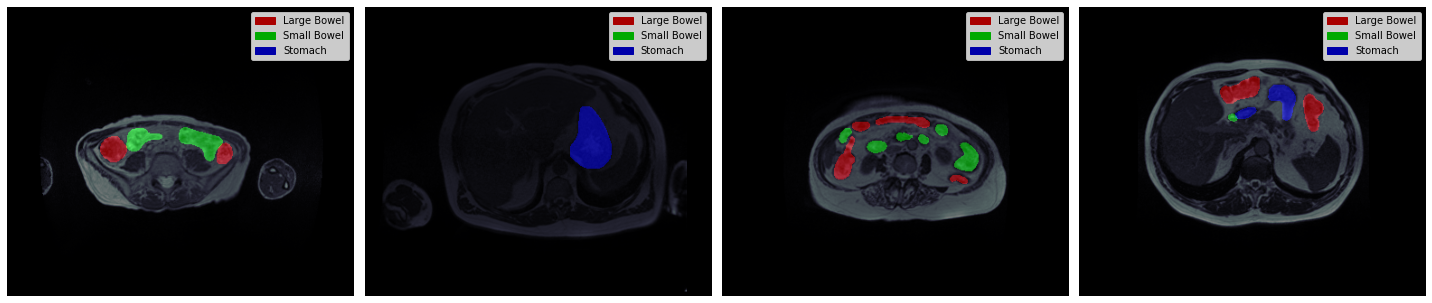

In [39]:
row = 1; col =4
plt.figure(figsize=(5 * col, 5 * row))
for i, id_ in enumerate(df[df['empty']==0].sample(frac=1.0)['id'].unique()[:row*col]):
    idf = df[df['id']==id_]
    img = load_img(idf.image_path.iloc[0])
    mask = load_msk(idf.mask_path.iloc[0])
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

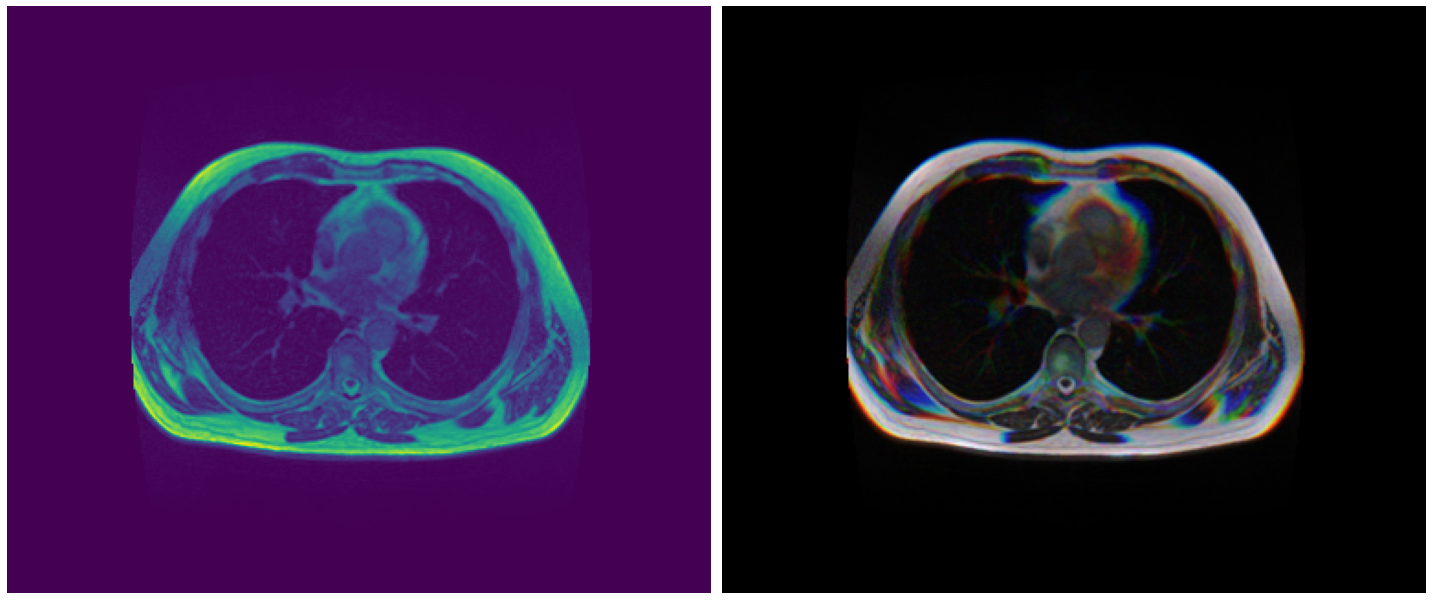

In [40]:
idx = 40
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
img = load_img(df.image_path[idx]).astype('float32')
img /= img.max()
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
imgs = load_imgs(df.image_paths[idx]).astype('float32')
imgs /= imgs.max(axis=(0, 1))
plt.imshow(imgs)
plt.axis('off')

plt.tight_layout()
plt.show()

In [41]:
SAVE_DATASET_DIR = r'/Users/zhuyue/Code/Datasets/uw-madison-gi-tract-image-segmentation-2.5d'

In [43]:
def save_mask(id_):
    row = df[df['id'] == id_].squeeze()

    img_paths = row.image_paths
    imgs = load_imgs(img_paths)
    np.save(f'{SAVE_DATASET_DIR}/imgs/{id_}.npy', imgs)

    msk_path = row.mask_path
    msk = load_msk(msk_path)
    np.save(f'{SAVE_DATASET_DIR}/masks/{id_}.npy', msk)

    return

In [48]:
ids = df['id'].unique()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_) for id_ in tqdm(ids, total=len(ids)))

  0%|          | 0/38496 [00:00<?, ?it/s]

In [49]:
df.to_csv(f'{SAVE_DATASET_DIR}/train.csv', index=False)